<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Comparing Object and Truth Tables</b> <br>
Contact author: Jeff Carlin <br>
Last verified to run: 2022-09-23 <br>
LSST Science Piplines version: Weekly 2022_39 <br>
Container size: medium <br>
Targeted learning level: beginner <br>

**Description:** An introduction to using the truth data for the Dark Energy Science Collaboration's DC2 data set, which formed the basis for the DP0 data products.

**Skills:** Use the TAP service with table joins to retrive truth data matched to the Object catalog.

**LSST Data Products:** TAP dp02_dc2_catalogs.Object, .MatchesTruth, and .TruthSummary tables. 

**Packages:** lsst.rsp.get_tap_service, lsst.rsp.retrieve_query

**Credit:** Originally developed by Jeff Carlin and the Rubin Community Engagement Team in the context of the Rubin DP0, with some help from Melissa Graham in the update from DP0.1 to DP0.2.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1.0. Introduction

This tutorial demonstrates how to extract a table containing data from both the DP0.2 object and truth tables.
The query returns the table `JOIN` of these two catalogs, which enables comparison of the recovered (measured) properties (e.g., fluxes, positions, magnitudes, etc.) to the simulated values that were assigned to each object when creating the DC2 simulations.

More information about the DC2 simulations that make up DP0 can be found in [the DC2 Data Release Note](https://ui.adsabs.harvard.edu/abs/2021arXiv210104855L/abstract).

### 1.1. Package imports

The [`matplotlib`](https://matplotlib.org/), [`numpy`](http://www.numpy.org/), [`pandas`](https://pandas.pydata.org/docs/), and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis. We will use these packages below, including the `matplotlib.pyplot` plotting sublibrary.

We also use the `warnings` package to minimize standard output within the notebook, and the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from astropy.units import UnitsWarning
import warnings
from lsst.rsp import get_tap_service, retrieve_query

### 1.2. Define functions and parameters

Ignore units warnings in this notebook, they are not cricital.

Set the pandas parameter for the maximum number of rows to display to 200.

In [2]:
warnings.simplefilter("ignore", category=UnitsWarning)
pandas.set_option('display.max_rows', 200)

Set `matplotlib` to show plots inline, within the notebook. Set various parameters to make plots look nice.

In [3]:
%matplotlib inline

# params = {'axes.labelsize': 22,
#           'font.size': 18,
#           'legend.fontsize': 14,
#           'xtick.major.width': 2,
#           'xtick.minor.width': 1,
#           'xtick.major.size': 12,
#           'xtick.minor.size': 6,
#           'xtick.direction': 'in',
#           'xtick.top': True,
#           'lines.linewidth': 2,
#           'axes.linewidth': 2,
#           'axes.labelweight': 2,
#           'axes.titleweight': 2,
#           'ytick.major.width': 2,
#           'ytick.minor.width': 1,
#           'ytick.major.size': 12,
#           'ytick.minor.size': 6,
#           'ytick.direction': 'in',
#           'ytick.right': True,
#           'figure.figsize': [10, 8],
#           'figure.facecolor': 'White'
#           }

# plt.rcParams.update(params)

Set up colors and plot symbols corresponding to the _ugrizy_ bands. These colors are the same as those used for _ugrizy_ bands in Dark Energy Survey (DES) publications, and are defined in <a href="https://github.com/DarkEnergySurvey/descolors">this github repository</a>.

In [4]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

To access tables, we will use the TAP service in a similar manner to what we showed in the [Intro to DP0 notebook](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/01_Intro_to_DP0_Notebooks.ipynb), and explored further in the [TAP tutorial notebook](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/02_Intermediate_TAP_Query.ipynb). See those notebooks for more details.

In [5]:
service = get_tap_service()

## 2.0. Discover truth data

The <a href="dp0-2.lsst.io">DP0.2 Documentation</a> contains a <a href="https://dp0-2.lsst.io/data-products-dp0-2/index.html#catalogs">list of all DP0.2 catalogs</a>, and also a link to the <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html">DP0.2 Schema Browser</a> where users can read about the available tables and their contents.

Alternatively, the Portal Aspect of the Rubin Science Platform can be used to browse catalog data.

Below, we show how to browse catalog data from a Notebook using the TAP service.

**Optional:** Print the names of all available tables.

In [6]:
# results = service.search("SELECT description, table_name FROM TAP_SCHEMA.tables")
# results_tab = results.to_table()

# for tablename in results_tab['table_name']:
#     print(tablename)

**Optional:** Print the table schema for the truth tables, `dp02_dc2_catalogs.MatchesTruth` and `.TruthSummary`.

Use the `.to_pandas()` method, and not just `.to_table()` (astropy table), so that all rows of the second cell display.

In [7]:
results = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.MatchesTruth'")

In [8]:
# results.to_table().to_pandas()

The above is fine if the full description is not needed, but there are some important details that are being hidden by the line truncation above.

Try this instead.

In [9]:
for c,columnname in enumerate(results['column_name']):
    print('%-25s %-200s' % (columnname, results['description'][c]))

id                        id for TruthSummary source. Potentially non-unique; use id_truth_type for JOINs.                                                                                                                        
id_truth_type             Combination of TruthSummary id and truth_type fields, used for JOINs.                                                                                                                                   
match_candidate           True for sources that were selected for matching                                                                                                                                                        
match_chisq               The chi-squared value of the (best) match                                                                                                                                                               
match_count               Number of candidate object matches within match radius            

In [10]:
del results

In [11]:
results = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.TruthSummary'")

In [12]:
# results.to_table().to_pandas()

In [13]:
for c,columnname in enumerate(results['column_name']):
    print('%-25s %-200s' % (columnname, results['description'][c]))

cosmodc2_hp               Healpix ID in cosmoDC2 (for galaxies only; -1 for stars and SNe)                                                                                                                                        
cosmodc2_id               Galaxy ID in cosmoDC2 (for galaxies only; -1 for stars and SNe)                                                                                                                                         
dec                       Declination                                                                                                                                                                                             
flux_g                    Static flux value in g                                                                                                                                                                                  
flux_g_noMW               Static flux value in g, without Milky Way extinction (i.e., deredd

In [14]:
del results

## 3.0. Retrieve truth data

_need three tables at once to do anything, etc._

### 3.1. A join of MatchesTruth and TruthSummary

As described in the column description, the column `id_truth_type` should be used to join the `MatchesTruth` and `TruthSummary` tables.

In [15]:
query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "
print(query)

SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type FROM dp02_dc2_catalogs.MatchesTruth AS mt JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 


In [16]:
%%time
results = service.search(query)

CPU times: user 1.22 s, sys: 35.9 ms, total: 1.26 s
Wall time: 6.55 s


In [17]:
results.to_table()

id_truth_type,match_objectId,ra,dec,truth_type
,,deg,deg,
object,int64,float64,float64,int64
7951745288_1,--,62.053461,-37.0410053,1
7951745355_1,--,61.9812383,-36.9238747,1
7945028323_1,--,62.0393933,-36.9227988,1
7943035857_1,--,62.1184027,-36.9847336,1
7951745569_1,--,62.0199128,-37.0204281,1
7945023879_1,--,62.0753674,-37.0497643,1
7945028173_1,--,61.9170764,-36.9284226,1
7945028038_1,--,61.8819527,-36.9909284,1


Print the fraction of retrieved truth objects that are matched to the dp02_dc2_catalogs.Object table of detections in the deeply coadded images.

In [18]:
tx = np.where(results['match_objectId'] > 1)[0]
print('Number: ', len(tx))
print('Fraction: ', np.round(len(tx)/len(results),2))

Number:  14850
Fraction:  0.23


In [19]:
del results

### 3.2. A triple-join of MatchesTruth, TruthSummary, and Objects

_note that the table length is now equal to the number of matched objects_

In [20]:
query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, "\
        "obj.coord_ra, obj.coord_dec "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "
print(query)

SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, obj.coord_ra, obj.coord_dec FROM dp02_dc2_catalogs.MatchesTruth AS mt JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 


In [21]:
%%time
results = service.search(query)

CPU times: user 415 ms, sys: 18 ms, total: 433 ms
Wall time: 1min


In [22]:
results.to_table()

id_truth_type,match_objectId,ra,dec,truth_type,coord_ra,coord_dec
,,deg,deg,,deg,deg
object,int64,float64,float64,int64,float64,float64
7953428896_1,1651220174314942513,61.9986552,-37.0608347,1,61.9987777,-37.060928
7950039897_1,1651220174314969864,62.0039618,-37.0934393,1,62.0038728,-37.0934628
7950120412_1,1651220174314942514,61.997711,-37.0608708,1,61.9975852,-37.0608277
7940028029_1,1651220174314972955,62.0041902,-37.0612893,1,62.0042559,-37.0611773
7954147367_1,1651220174314942125,62.0066751,-37.0895915,1,62.0066446,-37.0895808
7941101198_1,1651220174314942114,62.006342,-37.0901106,1,62.0063496,-37.090115
7939790348_1,1651220174314972719,62.0036757,-37.0624433,1,62.0035818,-37.0624464
7938395543_1,1651220174314936529,62.0046455,-37.0876139,1,62.0046648,-37.0876133


In [23]:
del results

### 3.3. A triple join to retrieve additional data for true galaxies that are matched to detected objects

_note above how the column names in the retrieved results have no provenance -- it is unclear, once the data is in the results table, from whence it came. thus, we use the AS statement to rename everything and keep track of what is truth (ts) and what is detection (obj)_

_note that we do truth_type = 1 for galaxies_

In [24]:
query = "SELECT mt.id_truth_type AS mt_id_truth_type, "\
        "mt.match_objectId AS mt_match_objectId, "\
        "ts.ra AS ts_ra, "\
        "ts.dec AS ts_dec, "\
        "ts.truth_type AS ts_truth_type, "\
        "ts.mag_r AS ts_mag_r, "\
        "ts.is_pointsource AS ts_is_pointsource, "\
        "ts.redshift AS ts_redshift, "\
        "ts.flux_u AS ts_flux_u, "\
        "ts.flux_g AS ts_flux_g, "\
        "ts.flux_r AS ts_flux_r, "\
        "ts.flux_i AS ts_flux_i, "\
        "ts.flux_z AS ts_flux_z, "\
        "ts.flux_y AS ts_flux_y, "\
        "obj.coord_ra AS obj_coord_ra, "\
        "obj.coord_dec AS obj_coord_dec, "\
        "obj.refExtendedness AS obj_refExtendedness, "\
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "\
        "obj.u_cModelFlux AS obj_u_cModelFlux, "\
        "obj.g_cModelFlux AS obj_g_cModelFlux, "\
        "obj.r_cModelFlux AS obj_r_cModelFlux, "\
        "obj.i_cModelFlux AS obj_i_cModelFlux, "\
        "obj.z_cModelFlux AS obj_z_cModelFlux, "\
        "obj.y_cModelFlux AS obj_y_cModelFlux "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "\
        "AND ts.truth_type = 1 "\
        "AND obj.detect_isPrimary = 1"
print(query)

SELECT mt.id_truth_type AS mt_id_truth_type, mt.match_objectId AS mt_match_objectId, ts.ra AS ts_ra, ts.dec AS ts_dec, ts.truth_type AS ts_truth_type, ts.mag_r AS ts_mag_r, ts.is_pointsource AS ts_is_pointsource, ts.redshift AS ts_redshift, ts.flux_u AS ts_flux_u, ts.flux_g AS ts_flux_g, ts.flux_r AS ts_flux_r, ts.flux_i AS ts_flux_i, ts.flux_z AS ts_flux_z, ts.flux_y AS ts_flux_y, obj.coord_ra AS obj_coord_ra, obj.coord_dec AS obj_coord_dec, obj.refExtendedness AS obj_refExtendedness, scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, obj.u_cModelFlux AS obj_u_cModelFlux, obj.g_cModelFlux AS obj_g_cModelFlux, obj.r_cModelFlux AS obj_r_cModelFlux, obj.i_cModelFlux AS obj_i_cModelFlux, obj.z_cModelFlux AS obj_z_cModelFlux, obj.y_cModelFlux AS obj_y_cModelFlux FROM dp02_dc2_catalogs.MatchesTruth AS mt JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId WHERE CONTAINS(POINT('I

In [25]:
%%time
results = service.search(query)

CPU times: user 1.45 s, sys: 38.8 ms, total: 1.49 s
Wall time: 2min 2s


In [26]:
results.to_table()

mt_id_truth_type,mt_match_objectId,ts_ra,ts_dec,ts_truth_type,ts_mag_r,ts_is_pointsource,ts_redshift,ts_flux_u,ts_flux_g,ts_flux_r,ts_flux_i,ts_flux_z,ts_flux_y,obj_coord_ra,obj_coord_dec,obj_refExtendedness,obj_cModelMag_r,obj_u_cModelFlux,obj_g_cModelFlux,obj_r_cModelFlux,obj_i_cModelFlux,obj_z_cModelFlux,obj_y_cModelFlux
,,deg,deg,,mag,,,nJy,nJy,nJy,nJy,nJy,nJy,deg,deg,,,nJy,nJy,nJy,nJy,nJy,nJy
object,int64,float64,float64,int64,float32,int32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7937520497_1,1651220174314942188,62.0631717,-37.0851535,1,26.5802,0,0.169322,11.7633,40.904,84.708,116.048,140.842,156.777,62.0631616,-37.0851577,1.0,26.435226894569162,49.8268484,37.8295932,96.8075529,117.0260118,264.3213179,211.0691218
7939237713_1,1651220174314942137,62.0137322,-37.0886972,1,26.413,0,0.898453,47.7982,61.2932,98.8109,224.464,292.576,301.52,62.0137364,-37.0886897,0.0,26.267795066448812,-4.916292,65.0595635,112.9488916,116.6189279,235.9278143,444.3774098
7937931047_1,1651220174314942058,62.0138745,-37.0943472,1,27.1415,0,0.484837,7.14249,16.2534,50.5128,69.9921,80.9253,89.1969,62.0138602,-37.0943699,1.0,26.548765614745903,-85.9313281,37.4202325,87.1954361,76.969484,-10.617475,-52.5909527
7938410309_1,1651220174314942062,62.0216218,-37.0940865,1,26.5848,0,0.692285,21.5376,35.3664,84.3479,172.323,196.091,217.03,62.0216146,-37.0940046,1.0,26.549860778262776,-32.9821726,5.1067847,87.1075279,87.1291422,223.9540885,171.9813491
7943494350_1,1651220174314942186,62.0460419,-37.0851636,1,25.7713,0,1.5453,214.909,205.737,178.433,211.608,227.969,332.504,62.0460374,-37.0851656,1.0,25.524042781221297,191.3976427,194.927821,224.0695735,161.9669021,506.5320896,514.7667773
7952572939_1,1651220174314942187,62.0206409,-37.0852387,1,26.8998,0,2.28483,60.8984,69.5424,63.1076,56.4984,51.6571,48.8786,62.0206491,-37.0852495,1.0,26.37253603074558,79.7359643,67.8704776,102.561789,62.9394419,261.8517136,262.3373621
7955560737_1,1651220174314942039,62.0340338,-37.0958165,1,26.4324,0,2.66586,41.0208,78.7332,97.0556,80.7597,73.5734,84.9182,62.0340167,-37.0958263,1.0,26.327056757308654,-78.3055406,66.9730848,106.9491401,108.6753977,179.1911325,80.0936227
7940141975_1,1651220174314942041,62.0189947,-37.0957143,1,26.2838,0,1.04254,57.5223,71.3749,111.294,199.083,363.826,394.051,62.0188969,-37.0956707,1.0,26.70139556924154,3.9745983,54.8125248,75.7603151,76.4201446,418.8167732,334.5211718


Notice that there is no `del results` statement here.

Keep these results and use them below, in Section 4, to explore the retrieved data for true galaxies.

## 4.0. Compare true and measured properties

### 4.1. Plot coordinate offsets for true galaxies

Below, plot the difference between the true and detected declination veruse the difference between the true and detected right ascension. 

See that the scatter is less than about 0.5 arcseconds. For the LSST Science Camera's platescale of 0.2 arcsec per pixel, that's a measurement accuracy of 2.5 pixels.

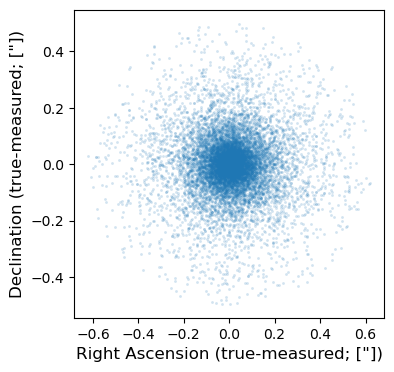

In [27]:
fig = plt.figure(figsize=(4, 4))
plt.plot(3600*(results['ts_ra']-results['obj_coord_ra']), \
         3600*(results['ts_dec']-results['obj_coord_dec']), \
         'o', ms=2, alpha=0.2, mew=0)
plt.xlabel('Right Ascension (true-measured; ["])', fontsize=12)
plt.ylabel('Declination (true-measured; ["])', fontsize=12)
plt.show()

### 4.2. How many true galaxies are measured as point sources?

First determine the number of true galaxies that are truely point sources (it is zero).

In [28]:
x = np.where(results['ts_is_pointsource'])[0]
print('Number: ', len(x))
print('Fraction: ', np.round(len(x)/len(results['ts_is_pointsource']),2))
del x

Number:  0
Fraction:  0.0


Next, the number of true galaxies that are measured as point sources, or in other words, have a measured `refExtendedness` equal to zero.

In this example, the following cell will report that 19% of true galaxies appear as point sources.

In [29]:
x = np.where(results['obj_refExtendedness'] == 0)[0]
print('Number: ', len(x))
print('Fraction: ', np.round(len(x)/len(results['ts_is_pointsource']),2))
del x

Number:  2819
Fraction:  0.19


The fact that 10% of the true galaxies retrieved from the catalog appear point-like does not necessarily indicate an error in the measurement pipelines. For example, very small or very distant galaxies can appear point like, even if the simulation knew they were extended. It is left as an exercise for the learner to explore what types of galaxies are measured to be point-like.

### 4.3. Compare true and measured r-band magnitudes for true galaxies

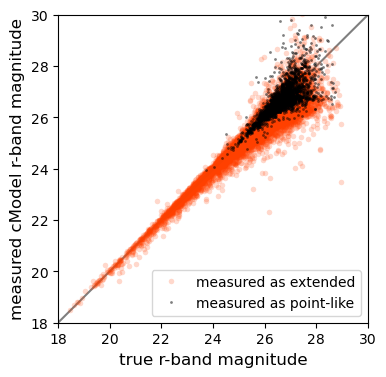

In [30]:
fig = plt.figure(figsize=(4, 4))
plt.plot([18,32], [18,32], ls='solid', color='black', alpha=0.5)
x = np.where(results['obj_refExtendedness'] == 1)[0]
plt.plot(results['ts_mag_r'][x], results['obj_cModelMag_r'][x], \
         'o', ms=4, alpha=0.2, mew=0, color=plot_filter_colors['r'],\
         label='measured as extended')
del x
x = np.where(results['obj_refExtendedness'] == 0)[0]
plt.plot(results['ts_mag_r'][x], results['obj_cModelMag_r'][x], \
         'o', ms=2, alpha=0.5, mew=0, color='black',\
         label='measured as point-like')
del x
plt.xlabel('true r-band magnitude', fontsize=12)
plt.ylabel('measured cModel r-band magnitude', fontsize=12)
plt.legend(loc='lower right')
plt.xlim([18,30])
plt.ylim([18,30])
plt.show()

### 4.4. Compare true and measured fluxes in all filters for true galaxies

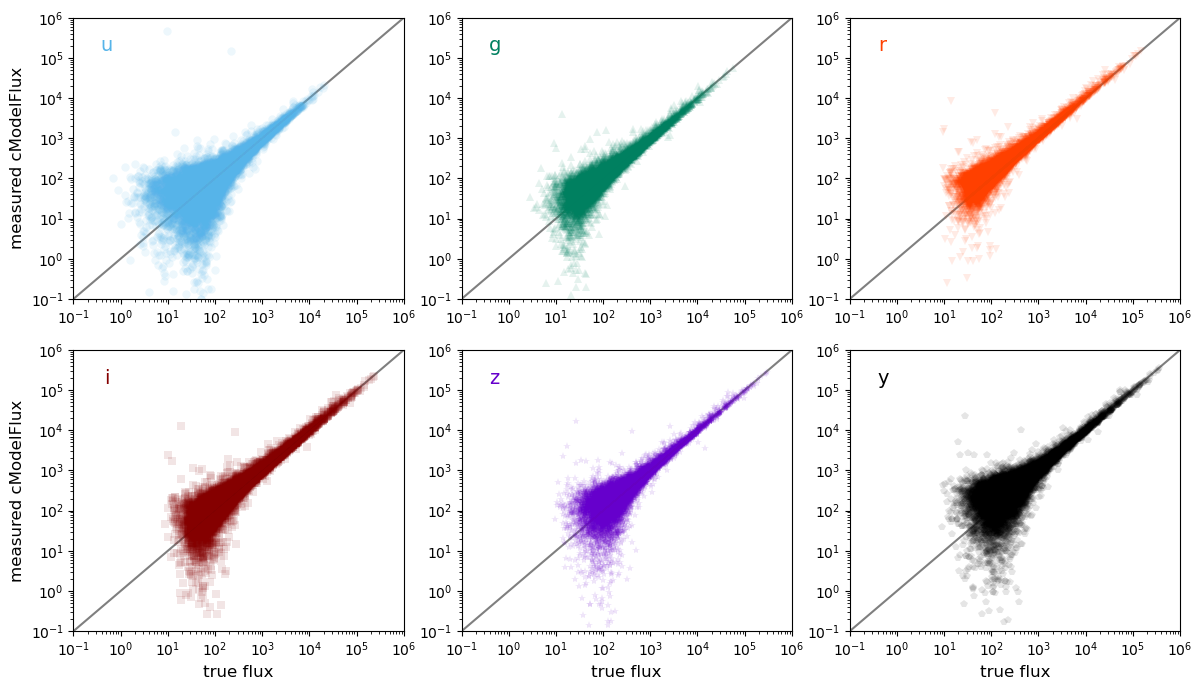

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
i=0
j=0
for f,filt in enumerate(plot_filter_labels):
    ax[i,j].plot([0.1,1e6], [0.1,1e6], ls='solid', color='black', alpha=0.5)
    ax[i,j].plot(results['ts_flux_'+filt], results['obj_'+filt+'_cModelFlux'], \
                 plot_filter_symbols[filt], color=plot_filter_colors[filt], \
                 alpha=0.1, mew=0, label=filt)
    ax[i,j].loglog()
    ax[i,j].text(0.1, 0.9, filt, horizontalalignment='center', verticalalignment='center',
                 transform = ax[i,j].transAxes, color=plot_filter_colors[filt], fontsize=14)
    ax[i,j].set_xlim([0.1,1e6])
    ax[i,j].set_ylim([0.1,1e6])
    j += 1
    if j == 3:
        i += 1
        j = 0
ax[0,0].set_ylabel('measured cModelFlux', fontsize=12)
ax[1,0].set_ylabel('measured cModelFlux', fontsize=12)
ax[1,0].set_xlabel('true flux', fontsize=12)
ax[1,1].set_xlabel('true flux', fontsize=12)
ax[1,2].set_xlabel('true flux', fontsize=12)
plt.tight_layout()
plt.show()

### 4.5. Compare CMDs for true and measured properties of true galaxies

/tmp/ipykernel_9968/3242911588.py:5: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(-2.5*np.log10(results['obj_g_cModelFlux']/results['obj_r_cModelFlux']), results['obj_cModelMag_r'], \
/tmp/ipykernel_9968/3242911588.py:5: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(-2.5*np.log10(results['obj_g_cModelFlux']/results['obj_r_cModelFlux']), results['obj_cModelMag_r'], \


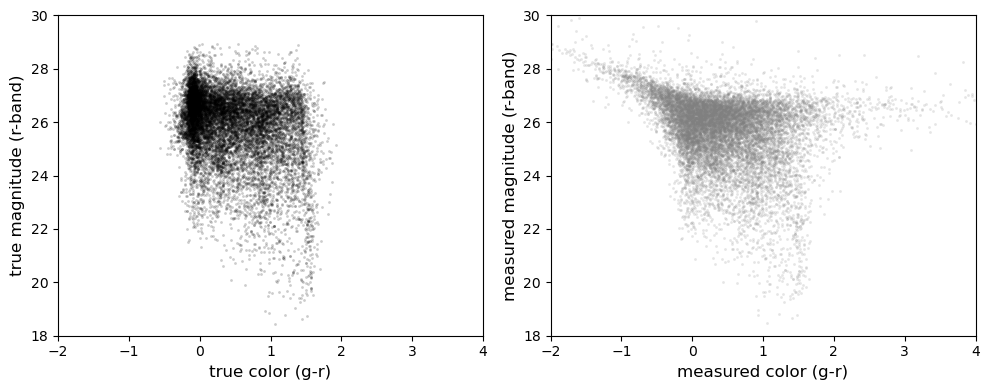

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(-2.5*np.log10(results['ts_flux_g']/results['ts_flux_r']), results['ts_mag_r'], \
           'o', ms=2, alpha=0.2, mew=0, color='black')

ax[1].plot(-2.5*np.log10(results['obj_g_cModelFlux']/results['obj_r_cModelFlux']), results['obj_cModelMag_r'], \
           'o', ms=2, alpha=0.2, mew=0, color='grey')
ax[0].set_xlabel('true color (g-r)', fontsize=12)
ax[0].set_ylabel('true magnitude (r-band)', fontsize=12)
ax[0].set_xlim([-2, 4])
ax[0].set_ylim([18, 30])
ax[1].set_xlabel('measured color (g-r)', fontsize=12)
ax[1].set_ylabel('measured magnitude (r-band)', fontsize=12)
ax[1].set_xlim([-2, 4])
ax[1].set_ylim([18, 30])
plt.tight_layout()
plt.show()

At above right, the effect of measurement uncertainties are correlated between the _x_ and _y_ axes because the r-band data is included in both. Below, the i-band and the z-band are insted used for color. See how the effect of measurement uncertainties changes.

/tmp/ipykernel_9968/2872694802.py:5: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(-2.5*np.log10(results['obj_i_cModelFlux']/results['obj_z_cModelFlux']), results['obj_cModelMag_r'], \
/tmp/ipykernel_9968/2872694802.py:5: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(-2.5*np.log10(results['obj_i_cModelFlux']/results['obj_z_cModelFlux']), results['obj_cModelMag_r'], \


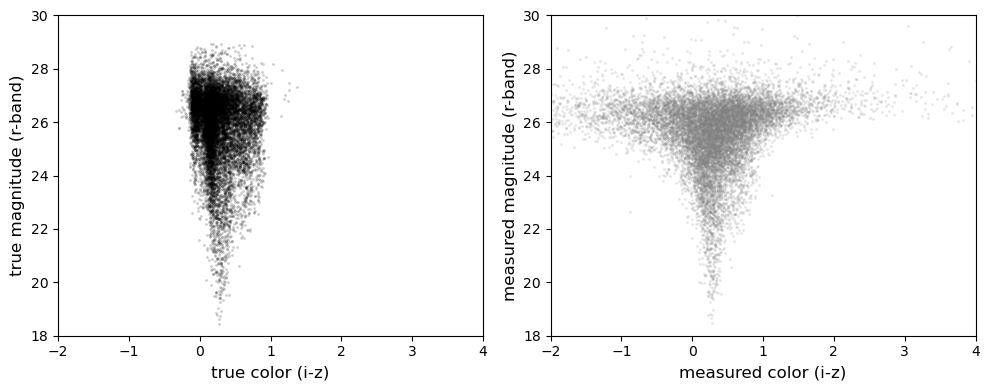

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(-2.5*np.log10(results['ts_flux_i']/results['ts_flux_z']), results['ts_mag_r'], \
           'o', ms=2, alpha=0.2, mew=0, color='black')

ax[1].plot(-2.5*np.log10(results['obj_i_cModelFlux']/results['obj_z_cModelFlux']), results['obj_cModelMag_r'], \
           'o', ms=2, alpha=0.2, mew=0, color='grey')
ax[0].set_xlabel('true color (i-z)', fontsize=12)
ax[0].set_ylabel('true magnitude (r-band)', fontsize=12)
ax[0].set_xlim([-2, 4])
ax[0].set_ylim([18, 30])
ax[1].set_xlabel('measured color (i-z)', fontsize=12)
ax[1].set_ylabel('measured magnitude (r-band)', fontsize=12)
ax[1].set_xlim([-2, 4])
ax[1].set_ylim([18, 30])
plt.tight_layout()
plt.show()

## 5.0 Exercises for the learner

1. Repeat the query in Section 3.3, but instead of only retrieving true galaxies (`ts.truth_type = 1`), include stars, which have a `truth_type` of 2. 

2. Since stars are point sources, instead of only retrieving `cModelFlux` measurements, also retrieve `psfFlux` from the Object catalog, because PSF-fit fluxes are more appropriate for point sources.

3. As mentioned in Section 4.2, it is left as an exercise for the learner to explore what types of galaxies are measured to be point-like.

# MLG EDITED UP TO HERE SO FAR

## 3. Extract a table of joined results from two tables, using a single query within ADQL

For those who are not familiar with databases, the simplest way of accomplishing the task might seem to be querying the two tables (Object and Truth-Match) separately, then matching them afterwards. This would work, but it is not the best use of the resources that are available. As seen in the [Advanced TAP/ADQL Usage in the Portal Aspect](https://dp0-1.lsst.io/tutorials-examples/index-portal-advanced.html#examples-dp0-1-portal-advanced) tutorial, the table JOIN can be done directly with ADQL. Not only will this save you a few steps, it should also execute much faster.

For this exploration, we will select a small region of sky around a random RA, Dec position. The following cell reads data centered on (RA, Dec) = (62.0, -37.0) degrees, within a radius of 0.1 degrees, from both the Object and Truth-Match table, then joins database entries where `match_objectId` from Truth-Match equals `objectId` from the Object table. Note that we are selecting only a subset of the columns seen in the schema above. You can add or remove columns as you wish.

Note that for the Object table we select all objects within the cone-shaped region of interest. In the Truth-Match table, we restrict the results to objects satisfying "match_objectId >= 0 AND is_good_match = 1". According to the Truth-Match schema above, the `is_good_match` flag is "True if this object--truth matching pair satisfies all matching criteria" as laid out in the [DESC DC2 Release Note](https://ui.adsabs.harvard.edu/abs/2021arXiv210104855L/abstract). We'll use that to select "good" matches. In the column description for `match_objectId` from above, it says "objectId of the matching object entry (-1 for unmatched truth entries)." Thus the criterion "match_objectId >= 0" removes the unmatched entries, leaving us with only the truth-table entries that were detected and appear in the Object table.


In [ ]:
# Define the query
query = "SELECT obj.objectId, obj.ra, obj.dec, obj.mag_g, obj.mag_r, "\
        "obj.mag_i, obj.mag_g_cModel, obj.mag_r_cModel, obj.mag_i_cModel, "\
        "obj.psFlux_g, obj.psFlux_r, obj.psFlux_i, obj.cModelFlux_g, "\
        "obj.cModelFlux_r, obj.cModelFlux_i, obj.tract, obj.patch, "\
        "obj.extendedness, obj.good, obj.clean, "\
        "truth.mag_r as truth_mag_r, truth.match_objectId, "\
        "truth.flux_g, truth.flux_r, truth.flux_i, truth.truth_type,  "\
        "truth.match_sep, truth.is_variable "\
        "FROM dp01_dc2_catalogs.object as obj "\
        "JOIN dp01_dc2_catalogs.truth_match as truth "\
        "ON truth.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec), "\
        "CIRCLE('ICRS', 62.0, -37.0, 0.10)) = 1 "\
        "AND truth.match_objectid >= 0 "\
        "AND truth.is_good_match = 1"
print(query)

In [ ]:
%%time
truth_plus_meas = service.search(query)
print('Query returned %s matched objects.' % len(truth_plus_meas))

Notice the `%%time` [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) we used. This was included to highlight that selecting more than 14000 objects from two tables and joining them takes less than 2 seconds (typically). Doing two separate queries, then joining them using `pandas`, typically takes more than a full minute.

In [ ]:
# Print the names of the fields in the returned table:

truth_plus_meas.fieldnames

## 4. Compare table values by plotting

In [ ]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 18,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Compare the measurements from the Object table to the "true" values for some objects.

To do this, we will separate the "stars" and "galaxies" using the `truth_type` column from the Truth-Match table. Simulated stars have `truth_type = 2`, and galaxies, `truth_type = 1`.

After separating stars and galaxies, we'll compare the recovered flux to the "true" value that was simulated for each object (as a ratio of the fluxes).

In [ ]:
star = np.where(truth_plus_meas['truth_type'] == 2)
gx = np.where(truth_plus_meas['truth_type'] == 1)

Just to confirm that things look like we expect, let's plot a color-magnitude (g vs. g-i) and color-color (r-i vs. g-r) diagram.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plt.sca(ax[0])  # set the first axis as current

plt.plot(truth_plus_meas['mag_g_cModel'][gx] - truth_plus_meas['mag_i_cModel'][gx],
         truth_plus_meas['mag_g_cModel'][gx], 'k.', alpha=0.2, label='galaxies')
plt.plot(truth_plus_meas['mag_g_cModel'][star] - truth_plus_meas['mag_i_cModel'][star],
         truth_plus_meas['mag_g_cModel'][star], 'ro', label='stars')
plt.legend(loc='upper left')
plt.xlabel(r'$(g-i)$')
plt.ylabel(r'$g$')
plt.xlim(-1.8, 4.3)
plt.ylim(29.3, 16.7)
plt.minorticks_on()

plt.sca(ax[1])  # set the first axis as current
plt.plot(truth_plus_meas['mag_g_cModel'][gx] - truth_plus_meas['mag_r_cModel'][gx],
         truth_plus_meas['mag_r_cModel'][gx] - truth_plus_meas['mag_i_cModel'][gx],
         'k.', alpha=0.1, label='galaxies')
plt.plot(truth_plus_meas['mag_g_cModel'][star] - truth_plus_meas['mag_r_cModel'][star],
         truth_plus_meas['mag_r_cModel'][star] - truth_plus_meas['mag_i_cModel'][star],
         'ro', label='stars')
plt.legend(loc='upper left')
plt.xlabel(r'$(g-r)$')
plt.ylabel(r'$(r-i)$')
plt.xlim(-1.3, 2.3)
plt.ylim(-1.3, 2.8)
plt.minorticks_on()

plt.tight_layout()
plt.show()

Looks pretty normal - the stellar locus in color-color space is right where one expects it to be, and the galaxies dominate at the faint end of the CMD. 

Now let's compare the fluxes:

In [ ]:
plt.rcParams.update({'figure.figsize': (11, 10)})

plt.plot(truth_plus_meas['truth_mag_r'][gx],
         truth_plus_meas['cModelFlux_r'][gx] / truth_plus_meas['flux_r'][gx],
         'k.', alpha=0.2, label='galaxies')
plt.plot(truth_plus_meas['truth_mag_r'][star],
         truth_plus_meas['cModelFlux_r'][star] / truth_plus_meas['flux_r'][star],
         'ro', label='stars')
plt.legend(loc='upper left')
plt.xlabel(r'$r$ magnitude (truth)')
plt.ylabel(r'$f_{\rm meas}/f_{\rm truth}$')
plt.ylim(0.15, 2.15)
plt.xlim(17.6, 27.8)
plt.minorticks_on()
plt.show()

Well, that looks good -- the ratio of measured to true fluxes is centered on 1.0. It seems like the fluxes are recovered pretty well, on average.

Congratulations! You have now learned how to compare measurements in the DP0.1 catalogs to the "true" simulated properties of objects. Have fun exploring more properties!